In [1]:
import math
import numpy as np
import keras
from keras import ops
from keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt

# Setting seed for reproducibiltiy
SEED = 42
keras.utils.set_random_seed(SEED)

In [2]:
import os
import cv2
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, MaxPooling2D, Flatten,Conv2D,Reshape, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras import losses
from tensorflow.keras.metrics import Recall, Precision
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import shutil
import sys
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import  preprocess_input
from keras.utils import to_categorical
import os
import cv2 as cv
from sklearn.metrics import roc_auc_score
#import drive
from tensorflow.keras.utils import image_dataset_from_directory
from google.colab import drive
from sklearn.utils import shuffle
drive.mount('/content/drive')
print ('modules loaded')

Mounted at /content/drive
modules loaded


In [3]:
train_dir = "/content/drive/MyDrive/Cropped_Rf_data_resolution/Train"
test_dir =  "/content/drive/MyDrive/Cropped_Rf_data_resolution/Test"
val_dir =  "/content/drive/MyDrive/Cropped_Rf_data_resolution/Val"
# Set up the image dimensions
img_height = 32
img_width = 32
# Define a function to preprocess the images
def preprocess_images(data_dir):
    X = []
    y = []

    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.png'):
                    img_path = os.path.join(class_dir, file_name)
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, (img_height, img_width))
                    img = img / 255.0
                    X.append(img)
                    y.append(class_name)

    X = np.array(X)
    y = np.array(y)
    X,y=shuffle(X,y,random_state=42)

    return X, y

In [4]:
# Preprocess the training data
X_train, y_train = preprocess_images(train_dir)
# Preprocess the testing data
X_test, y_test = preprocess_images(test_dir)
# Preprocess the validation data
X_val, y_val = preprocess_images(val_dir)

In [5]:
from sklearn.preprocessing import LabelEncoder

# Assuming y_train, y_val, y_test are your label arrays
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)
X_train = X_train.astype("float32")
x_test = X_test.astype("float32")
X_val = X_val.astype("float32")


In [6]:
# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 256

# AUGMENTATION
IMAGE_SIZE = 72
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# TRAINING
EPOCHS = 50

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

1357


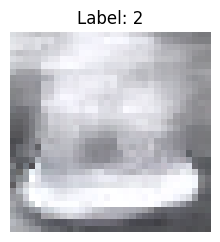

In [8]:
import matplotlib.pyplot as plt

# Function to plot a batch of images
print(len(X_train))
def plot_images(X, y, num_images=5):
    plt.figure(figsize=(15, 15))
    for i in range(15,20):
        plt.subplot(1, num_images, 1)
        plt.imshow(X[i])  # Show the image
        plt.title(f"Label: {y[i]}")  # Show the label
        plt.axis('off')
    plt.show()

# Plot a few images from the augmented training set
plot_images(X_train,y_train_encoded, num_images=5)

In [9]:

class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = ops.image.crop_images(
            images,
            top_cropping=crop_height,
            left_cropping=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = ops.image.pad_images(
            crop,
            top_padding=shift_height,
            left_padding=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = ops.concatenate(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = ops.image.extract_patches(
            images=images,
            size=(self.patch_size, self.patch_size),
            strides=[1, self.patch_size, self.patch_size, 1],
            dilation_rate=1,
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'shifted_patch_tokenization', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


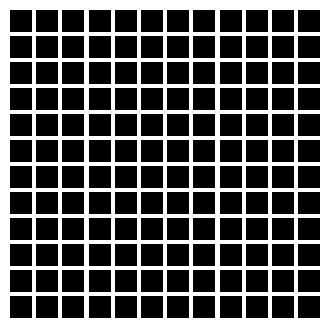

ORIGINAL


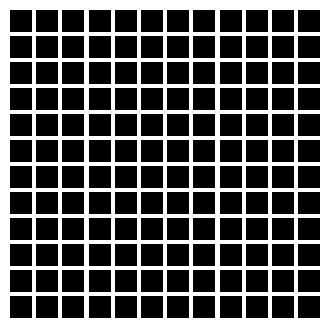

LEFT-UP


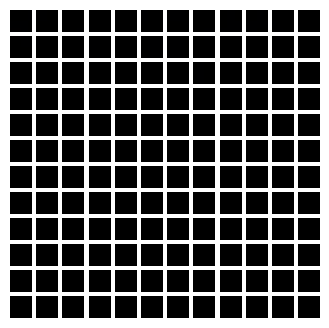

LEFT-DOWN


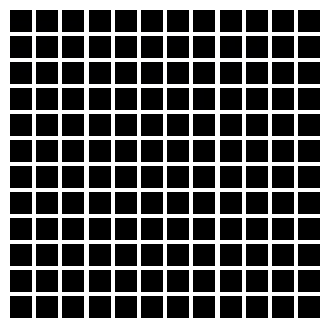

RIGHT-UP


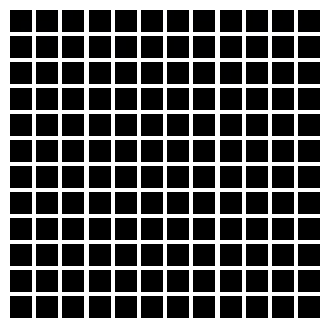

RIGHT-DOWN


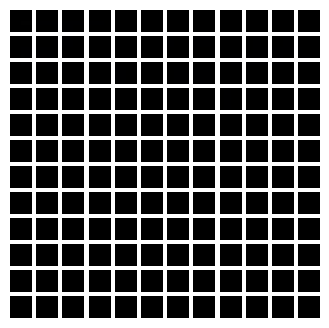

In [10]:
# Get a random image from the training dataset
# and resize the image
image = X_train[np.random.choice(range(X_train.shape[0]))]
resized_image = ops.cast(
    ops.image.resize(ops.convert_to_tensor([image]), size=(IMAGE_SIZE, IMAGE_SIZE)),
    dtype="float32",
)

# Vanilla patch maker: This takes an image and divides into
# patches as in the original ViT paper
(token, patch) = ShiftedPatchTokenization(vanilla=True)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
count = 1
plt.figure(figsize=(4, 4))
for row in range(n):
    for col in range(n):
        plt.subplot(n, n, count)
        count = count + 1
        image = ops.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 3))
        plt.imshow(image)
        plt.axis("off")
plt.show()

# Shifted Patch Tokenization: This layer takes the image, shifts it
# diagonally and then extracts patches from the concatinated images
(token, patch) = ShiftedPatchTokenization(vanilla=False)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
for index, name in enumerate(shifted_images):
    print(name)
    count = 1
    plt.figure(figsize=(4, 4))
    for row in range(n):
        for col in range(n):
            plt.subplot(n, n, count)
            count = count + 1
            image = ops.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 5 * 3))
            plt.imshow(image[..., 3 * index : 3 * index + 3])
            plt.axis("off")
    plt.show()

In [11]:

class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = ops.arange(start=0, stop=self.num_patches, step=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches


In [12]:

class MultiHeadAttentionLSA(layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = keras.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = ops.multiply(query, 1.0 / self.tau)
        attention_scores = ops.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = ops.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores


In [13]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation="gelu")(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Build the diagonal attention mask
diag_attn_mask = 1 - ops.eye(NUM_PATCHES)
diag_attn_mask = ops.cast([diag_attn_mask], dtype="int8")

In [14]:
INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = 4
def create_vit_classifier(vanilla=False):
    inputs = layers.Input(shape=INPUT_SHAPE)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [15]:

class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = ops.array(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = ops.cos(
            self.pi
            * (ops.cast(step, dtype="float32") - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = (
                slope * ops.cast(step, dtype="float32") + self.warmup_learning_rate
            )
            learning_rate = ops.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return ops.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


def run_experiment(model):
    total_steps = int((len(X_train) / BATCH_SIZE) * EPOCHS)
    warmup_epoch_percentage = 0.10
    warmup_steps = int(total_steps * warmup_epoch_percentage)
    scheduled_lrs = WarmUpCosine(
        learning_rate_base=LEARNING_RATE,
        total_steps=total_steps,
        warmup_learning_rate=0.0,
        warmup_steps=warmup_steps,
    )

    optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    history = model.fit(
        x=X_train,
        y=y_train_encoded,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.1,
    )
    _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test_encoded, batch_size=BATCH_SIZE)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


# Run experiments with the vanilla ViT
vit = create_vit_classifier(vanilla=True)
history = run_experiment(vit)

# Run experiments with the Shifted Patch Tokenization and
# Locality Self Attention modified ViT
vit_sl = create_vit_classifier(vanilla=False)
history = run_experiment(vit_sl)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'shifted_patch_tokenization_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 755ms/step - accuracy: 0.3669 - loss: 6.5868 - top-5-accuracy: 1.0000 - val_accuracy: 0.4485 - val_loss: 2.0445 - val_top-5-accuracy: 1.0000
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 356ms/step - accuracy: 0.5181 - loss: 1.9720 - top-5-accuracy: 1.0000 - val_accuracy: 0.5441 - val_loss: 1.0819 - val_top-5-accuracy: 1.0000
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step - accuracy: 0.6049 - loss: 1.1720 - top-5-accuracy: 1.0000 - val_accuracy: 0.7206 - val_loss: 0.6495 - val_top-5-accuracy: 1.0000
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 354ms/step - accuracy: 0.6618 - loss: 0.9411 - top-5-accuracy: 1.0000 - val_accuracy: 0.6912 - val_loss: 0.6998 - val_top-5-accuracy: 1.0000
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step - accuracy: 0.6902 - loss: 0.8248 - top-5-accuracy: 1.0000 - val_accuracy: 0.7794 - val_loss: 0.5928 - val_top-5-accuracy: 1.0000
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 358ms/step - accuracy: 0.7382 - loss: 0.7006 - top-5-accurac

In [17]:
results = vit.evaluate(x= X_test, y=y_test_encoded)
# Print the evaluation results
print("Loss:", results[0])
print("Accuracy:", results[1])
print("Precision:", results[2])  # Adjust this index based on your specific metrics


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8959 - loss: 0.2984 - top-5-accuracy: 1.0000
Loss: 0.3306005895137787
Accuracy: 0.8913043737411499
Precision: 1.0


In [18]:
results = vit_sl.evaluate(x= X_test, y=y_test_encoded)
# Print the evaluation results
print("Loss:", results[0])
print("Accuracy:", results[1])
print("Precision:", results[2])  # Adjust this index based on your specific metrics


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8871 - loss: 0.3632 - top-5-accuracy: 1.0000
Loss: 0.3824688792228699
Accuracy: 0.89673912525177
Precision: 1.0


In [60]:
vit_pred = vit.predict(x_test)
print(vit_pred)



6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 360ms/step
[[ -5.937502     6.374381    -5.1752253   13.770774  ]
 [ -5.8148007    3.4421318    1.4409419    6.7917056 ]
 [  2.2451375    4.107484    -3.0191374    2.3571327 ]
 [  4.9163165    7.137437     3.0966957   -4.3929553 ]
 [ -2.694672     8.153871     2.608868    -0.38364848]
 [ -4.0099206    4.5745616   -5.397332    13.158145  ]
 [ -1.4476984    1.3082819   -1.3506567    3.6955097 ]
 [ -1.2404864    2.628123     9.911026    -5.4922667 ]
 [  1.5815064   15.82817     -4.7276917    0.49212354]
 [  5.3160677   11.309949     1.338563    -5.6114173 ]
 [ -2.3458402    5.322489    -1.4116114    3.7844465 ]
 [ -2.8738081    5.9820447   -3.8981273    6.757465  ]
 [ -1.4305547    5.28157     11.778754    -5.307942  ]
 [  9.635918     7.028518    -1.3385406   -1.264904  ]
 [ -4.9361286    5.1809855   -4.000992    11.677814  ]
 [ -4.3532624    7.761687    -6.388628    10.554915  ]
 [ -4.9153113    3.3506894   -2.159249    11.06533   ]
 [ -4.331014     3.76098  

In [61]:
f=[]
for i in vit_pred:

  final_preds = np.argmax(i)
  f.append(final_preds)
g=np.array(f)

accuracy = accuracy_score(y_test_encoded, g)
print(accuracy,y_test_encoded,g)

0.8913043478260869 [3 3 1 1 1 3 3 2 1 1 1 1 2 0 3 3 3 3 2 3 1 1 1 3 3 1 3 3 0 1 2 3 1 1 2 3 0
 2 2 3 3 3 1 1 1 1 1 3 1 1 2 1 3 1 3 0 1 2 1 3 1 0 1 2 3 1 3 1 1 1 3 0 1 3
 3 1 3 3 1 1 1 0 3 1 1 3 1 2 1 2 3 1 3 3 1 1 3 3 1 2 2 2 3 1 1 2 0 1 3 1 1
 0 3 2 3 3 1 1 2 0 1 1 1 3 3 1 1 3 0 3 2 3 3 1 1 2 1 0 1 3 3 3 1 1 3 2 1 1
 1 0 2 3 1 3 0 3 3 1 3 3 0 1 3 1 0 3 3 1 1 1 1 1 1 1 2 1 0 3 2 1 3 1 0 1] [3 3 1 1 1 3 3 2 1 1 1 3 2 0 3 3 3 3 2 1 1 1 1 3 3 1 3 3 0 1 2 3 1 1 1 3 2
 2 2 3 3 1 1 1 1 1 1 0 1 1 2 1 3 0 3 0 1 2 1 3 1 3 1 2 3 1 3 1 1 1 3 1 1 3
 3 1 3 3 3 3 1 0 3 1 1 3 1 2 1 2 3 1 3 3 1 1 3 3 1 2 2 2 3 1 1 2 0 1 1 1 1
 0 3 2 3 3 3 1 2 0 3 1 1 3 3 1 1 3 1 3 2 3 3 1 1 2 1 0 1 3 3 3 3 1 3 2 1 1
 1 0 2 3 1 3 0 3 3 1 3 3 0 3 3 1 1 3 3 1 1 3 1 1 1 1 2 1 2 3 2 1 3 1 0 1]


In [63]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# assume y_true and y_pred are the ground truth and predicted labels respectively
# for a multi-class classification problem with classes 0 to n-1
cm = confusion_matrix(y_test_encoded, g)
report = classification_report(y_test_encoded, g)

# recall for each class can be obtained from the classification report
print(report)

              precision    recall  f1-score   support

           0       0.86      0.67      0.75        18
           1       0.91      0.89      0.90        80
           2       0.92      0.96      0.94        24
           3       0.87      0.94      0.90        62

    accuracy                           0.89       184
   macro avg       0.89      0.86      0.87       184
weighted avg       0.89      0.89      0.89       184



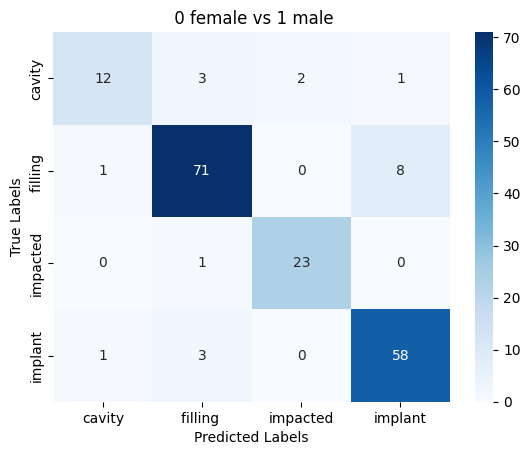

In [64]:
import seaborn as sns


conf_mat = confusion_matrix(y_test_encoded, g)
# Assuming you have a list of class names
class_names = ['cavity' , 'filling ','impacted','implant']

# Compute the confusion matrix

# Create a heatmap of the confusion matrix
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='g', xticklabels=class_names, yticklabels=class_names)

# Add labels and title to the plot
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(" 0 female vs 1 male")

# Show the plot
plt.show()

In [65]:

vit_sl_pred = vit_sl.predict(x_test)
print(vit_sl_pred)

print(y_test_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
[[-3.44918346e+00 -1.16496220e-01 -4.04121161e+00  1.06092615e+01]
 [-4.76742172e+00  1.92068624e+00  1.58467650e+00  6.33920527e+00]
 [ 1.58356547e+00  7.98797560e+00 -7.60190916e+00 -8.92766237e-01]
 [-1.92493594e+00  6.52604198e+00 -1.23702323e+00 -2.08965611e+00]
 [-2.40919471e+00  1.50326681e+00  2.93518353e+00 -4.41168165e+00]
 [-5.82651091e+00  1.42235434e+00 -8.44867897e+00  1.97642612e+01]
 [-2.14400911e+00 -1.19125021e+00 -4.80304480e-01  3.92394733e+00]
 [-3.24792242e+00  4.76154208e-01  5.01047707e+00 -2.92357302e+00]
 [-6.16185367e-01  1.79913406e+01 -1.00657434e+01 -6.86877680e+00]
 [-4.32067156e-01  6.10783243e+00 -1.28253329e+00 -4.50470495e+00]
 [-4.53694487e+00  5.31488323e+00 -2.78900576e+00  3.04363012e+00]
 [-3.72779584e+00  8.41934681e+00 -6.55910063e+00  1.93954897e+00]
 [-6.60105991e+00  1.00264597e+00  9.70471478e+00 -5.62312841e+00]
 [ 1.30729637e+01  3.87436271e+00 -1.54204588e+01 -1.29691422e+00]
 [-1.60495973e+00  4.042

In [66]:
f=[]
for i in vit_sl_pred:

  final_preds = np.argmax(i)
  f.append(final_preds)
g=np.array(f)

accuracy = accuracy_score(y_test_encoded, g)
print(accuracy,y_train_encoded,g)

0.8967391304347826 [2 1 1 ... 1 1 1] [3 3 1 1 2 3 3 2 1 1 1 1 2 0 3 3 3 3 2 0 1 1 1 3 3 1 3 3 0 1 2 3 1 1 3 1 0
 2 1 3 3 3 1 0 3 1 1 3 1 1 2 1 3 1 3 2 1 3 1 3 1 3 1 2 3 1 3 1 1 1 3 1 1 3
 3 1 3 3 3 1 1 0 3 1 3 3 1 2 1 2 3 1 3 3 1 1 1 3 1 2 2 2 3 1 1 2 0 1 1 1 1
 0 3 2 3 3 1 1 2 0 1 1 1 3 3 1 1 3 1 3 2 3 3 1 1 2 1 0 1 3 3 3 3 1 3 2 1 1
 1 0 2 3 1 3 0 0 3 1 3 3 0 1 3 1 1 3 3 1 1 1 1 1 1 1 2 1 0 3 2 1 3 1 0 1]


In [67]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# assume y_true and y_pred are the ground truth and predicted labels respectively
# for a multi-class classification problem with classes 0 to n-1
cm = confusion_matrix(y_test_encoded, g)
report = classification_report(y_test_encoded, g)

# recall for each class can be obtained from the classification report
print(report)

              precision    recall  f1-score   support

           0       0.81      0.72      0.76        18
           1       0.91      0.93      0.92        80
           2       0.91      0.88      0.89        24
           3       0.89      0.92      0.90        62

    accuracy                           0.90       184
   macro avg       0.88      0.86      0.87       184
weighted avg       0.90      0.90      0.90       184



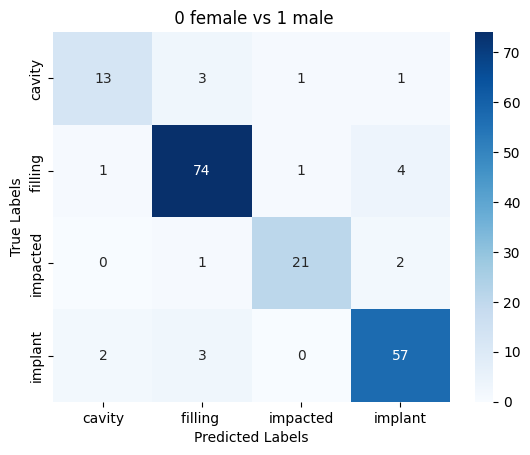

In [68]:
import seaborn as sns


conf_mat = confusion_matrix(y_test_encoded, g)
# Assuming you have a list of class names
class_names = ['cavity' , 'filling ','impacted','implant']

# Compute the confusion matrix

# Create a heatmap of the confusion matrix
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='g', xticklabels=class_names, yticklabels=class_names)

# Add labels and title to the plot
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(" 0 female vs 1 male")

# Show the plot
plt.show()

In [19]:
from IPython.display import display
import ipywidgets as widgets
import keras
from keras import ops
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model
from IPython.display import display, HTML
import cv2
from keras.saving import register_keras_serializable
from tensorflow.keras.models import load_model
from PIL import Image

In [59]:
image=""
image =cv2.imread(image)
image = Image.fromarray(image).resize((32, 32))
# Convert the image to a numpy array and normalize it
image_array = np.array(image) / 255.0
# Ensure the image has 3 channels (RGB), if not convert it
if image_array.shape[-1] != 3:
    image_array = np.stack((image_array,)*3, axis=-1)
# Reshape the image to match the model's input shape
image_array = image_array.reshape( -1,32, 32, 3)
vit_sl_pred = vit_sl.predict(image_array)
vit_sl_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


array([[ 3.6239846 , -3.0127707 , -0.16600189, -0.362469  ]],
      dtype=float32)

In [ ]:
vit.save

SyntaxError: invalid syntax (<ipython-input-46-c6190c3fb33e>, line 1)

In [ ]:
model=load_model("/content/vit_sl.h5")

ValueError: No model config found in the file at /content/vit_sl.h5.